In [8]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

def print_tree(node, depth=0):
    if node is None:
        return

    indent = "  " * depth
    if node.left is None and node.right is None:
        print(f"{indent}Leaf: Predict={node.predicted_class}, Samples={node.num_samples}, Entropy={node.gini:.4f}")
    else:
        print(f"{indent}Node: Feature={node.feature_index}, Threshold={node.threshold:.4f}, Entropy={node.gini:.4f}")
        print(f"{indent}  Left:")
        print_tree(node.left, depth + 1)
        print(f"{indent}  Right:")
        print_tree(node.right, depth + 1)

def entropy(y):
    counts = np.bincount(y)
    probabilities = counts / len(y)
    return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

def information_gain(y, y_left, y_right):
    p = len(y_left) / len(y)
    return entropy(y) - p * entropy(y_left) - (1 - p) * entropy(y_right)

def best_split(X, y):
    best_gain = -1
    split_idx, split_threshold = None, None
    for i in range(X.shape[1]):
        thresholds, classes = zip(*sorted(zip(X[:, i], y)))
        for j in range(1, len(y)):
            if classes[j] == classes[j - 1]:
                continue
            y_left, y_right = classes[:j], classes[j:]
            gain = information_gain(y, y_left, y_right)
            if gain > best_gain:
                best_gain = gain
                split_idx, split_threshold = i, thresholds[j]
    return split_idx, split_threshold, best_gain

class Node:
    def __init__(self, gini=None, num_samples=None, num_samples_per_class=None, predicted_class=None):
        self.gini = gini
        self.num_samples = num_samples
        self.num_samples_per_class = num_samples_per_class
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None


def grow_tree(X, y, depth=0, max_depth=None):
    num_samples_per_class = [np.sum(y == i) for i in np.unique(y)]
    predicted_class = np.argmax(num_samples_per_class)
    node = Node(
        gini=entropy(y),
        num_samples=len(y),
        num_samples_per_class=num_samples_per_class,
        predicted_class=predicted_class,
    )

    if depth < max_depth:
        idx, thr, gain = best_split(X, y)
        if gain > 0:
            indices_left = X[:, idx] < thr
            X_left, y_left = X[indices_left], y[indices_left]
            X_right, y_right = X[~indices_left], y[~indices_left]

            # pokud je jedna z množin prázdná ukončím další větvení
            if len(y_left) == 0 or len(y_right) == 0:
                return node

            node.feature_index = idx
            node.threshold = thr
            node.left = grow_tree(X_left, y_left, depth + 1, max_depth)
            node.right = grow_tree(X_right, y_right, depth + 1, max_depth)
    return node

def predict_tree(node, X):
    if node.left is None and node.right is None:
        return node.predicted_class
    if X[node.feature_index] < node.threshold:
        return predict_tree(node.left, X)
    else:
        return predict_tree(node.right, X)


data = pd.read_csv('iris.csv', delimiter=';')
#data = load_iris()
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].factorize()[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)
tree = grow_tree(X_train, y_train, max_depth=999)
print_tree(tree)

y_pred = [predict_tree(tree, x) for x in X_test]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=1)
recall = recall_score(y_test, y_pred, average='macro', zero_division=1)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=1)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Node: Feature=2, Threshold=3.3000, Entropy=1.5800
  Left:
  Leaf: Predict=0, Samples=35, Entropy=-0.0000
  Right:
  Node: Feature=3, Threshold=1.6000, Entropy=0.9926
    Left:
    Leaf: Predict=0, Samples=35, Entropy=-0.0000
    Right:
    Node: Feature=3, Threshold=1.8000, Entropy=0.4306
      Left:
      Node: Feature=0, Threshold=6.0000, Entropy=1.0000
        Left:
        Leaf: Predict=0, Samples=1, Entropy=-0.0000
        Right:
        Node: Feature=0, Threshold=7.2000, Entropy=0.9183
          Left:
          Leaf: Predict=0, Samples=2, Entropy=-0.0000
          Right:
          Leaf: Predict=0, Samples=1, Entropy=-0.0000
      Right:
      Node: Feature=2, Threshold=4.9000, Entropy=0.2108
        Left:
        Leaf: Predict=0, Samples=1, Entropy=-0.0000
        Right:
        Leaf: Predict=0, Samples=29, Entropy=-0.0000
Accuracy: 0.3111111111111111
Precision: 0.7703703703703703
Recall: 0.3333333333333333
F1 Score: 0.15819209039548024


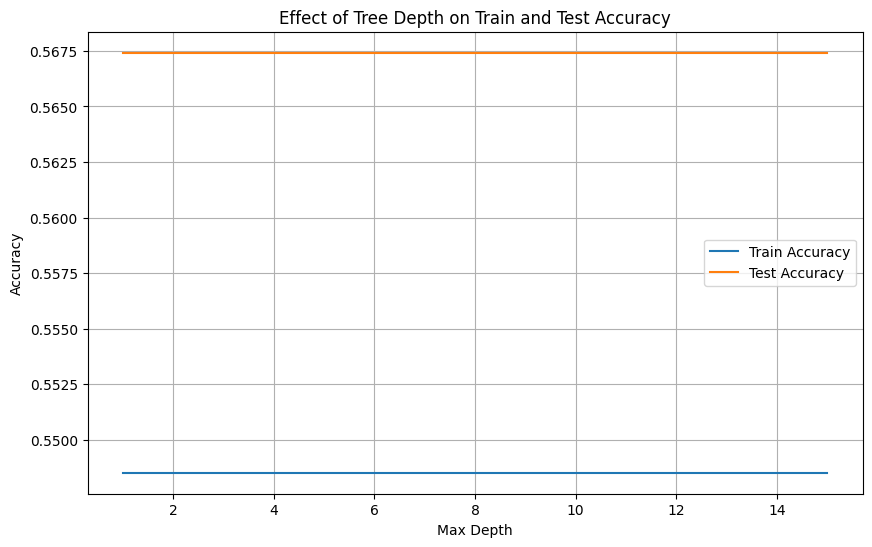

In [25]:
data = pd.read_csv('titanic_preprocessed.csv', delimiter=',')
X = data.iloc[:, :-1].values
y = data["Pclass"].factorize()[0]
# print(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

train_accuracies = []
test_accuracies = []

for max_depth in range(1, 16):
    tree = grow_tree(X_train, y_train, max_depth=max_depth)

    y_train_pred = [predict_tree(tree, x) for x in X_train]
    y_test_pred = [predict_tree(tree, x) for x in X_test]

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 16), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 16), test_accuracies, label='Test Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Effect of Tree Depth on Train and Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def print_tree(node, depth=0):
    if node is None:
        return

    indent = "  " * depth
    if node.left is None and node.right is None:
        print(f"{indent}Leaf: Predict={node.predicted_class}, Samples={node.num_samples}, Gini={node.gini:.4f}")
    else:
        print(f"{indent}Node: Feature={node.feature_index}, Threshold={node.threshold:.4f}, Gini={node.gini:.4f}")
        print(f"{indent}  Left:")
        print_tree(node.left, depth + 1)
        print(f"{indent}  Right:")
        print_tree(node.right, depth + 1)

def gini_index(data: pd.DataFrame, class_column: int):
    prob = 0.0
    labels = data[class_column].unique()
    for x in labels:
        p = data.loc[data[class_column] == x].shape[0] / data.shape[0]
        prob += p ** 2
    return 1 - prob

def information_gain(y, y_left, y_right):
    full_data = pd.DataFrame({0: y})
    left_data = pd.DataFrame({0: y_left})
    right_data = pd.DataFrame({0: y_right})
    p = len(y_left) / len(y)
    return gini_index(full_data, 0) - p * gini_index(left_data, 0) - (1 - p) * gini_index(right_data, 0)

def best_split(X, y):
    best_gain = -1
    split_idx, split_threshold = None, None
    for i in range(X.shape[1]):
        sorted_indices = np.argsort(X[:, i])
        sorted_X, sorted_y = X[sorted_indices], y[sorted_indices]

        for j in range(1, len(y)):
            if sorted_y[j] == sorted_y[j - 1]:
                continue
            y_left, y_right = sorted_y[:j], sorted_y[j:]
            gain = information_gain(y, y_left, y_right)
            if gain > best_gain:
                best_gain = gain
                split_idx = i
                split_threshold = (sorted_X[j - 1, i] + sorted_X[j, i]) / 2

    return split_idx, split_threshold, best_gain


class Node:
    def __init__(self, gini=None, num_samples=None, num_samples_per_class=None, predicted_class=None):
        self.gini = gini
        self.num_samples = num_samples
        self.num_samples_per_class = num_samples_per_class
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

def grow_tree(X, y, depth=0, max_depth=None):
    num_samples_per_class = [np.sum(y == i) for i in np.unique(y)]
    predicted_class = np.argmax(num_samples_per_class)
    node = Node(
        gini=gini_index(pd.DataFrame({0: y}), 0),
        num_samples=len(y),
        num_samples_per_class=num_samples_per_class,
        predicted_class=predicted_class,
    )

    if depth < max_depth:
        idx, thr, gain = best_split(X, y)
        if gain > 0:
            indices_left = X[:, idx] < thr
            X_left, y_left = X[indices_left], y[indices_left]
            X_right, y_right = X[~indices_left], y[~indices_left]

            # Stop splitting if one of the sides is empty
            if len(y_left) == 0 or len(y_right) == 0:
                return node

            node.feature_index = idx
            node.threshold = thr
            node.left = grow_tree(X_left, y_left, depth + 1, max_depth)
            node.right = grow_tree(X_right, y_right, depth + 1, max_depth)
    return node

def predict_tree(node, X):
    if node.left is None and node.right is None:
        return node.predicted_class
    if X[node.feature_index] < node.threshold:
        return predict_tree(node.left, X)
    else:
        return predict_tree(node.right, X)

# Load and split the dataset
data = pd.read_csv('iris.csv', delimiter=';')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].factorize()[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)
tree = grow_tree(X_train, y_train, max_depth=3)
print_tree(tree)

y_pred = [predict_tree(tree, x) for x in X_test]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=1)
recall = recall_score(y_test, y_pred, average='macro', zero_division=1)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=1)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Node: Feature=2, Threshold=2.6000, Gini=0.6644
  Left:
  Leaf: Predict=0, Samples=35, Gini=0.0000
  Right:
  Node: Feature=3, Threshold=1.6000, Gini=0.4949
    Left:
    Leaf: Predict=0, Samples=35, Gini=0.0000
    Right:
    Node: Feature=3, Threshold=1.8000, Gini=0.1609
      Left:
      Leaf: Predict=0, Samples=4, Gini=0.5000
      Right:
      Leaf: Predict=1, Samples=30, Gini=0.0644
Accuracy: 0.3111111111111111
Precision: 0.4942528735632184
Recall: 0.3333333333333333
F1 Score: 0.2170542635658915


In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def gini_index(data: pd.DataFrame, class_column: int):
    prob = 0.0
    labels = data[class_column].unique()
    for x in labels:
        p = data.loc[data[class_column] == x].shape[0] / data.shape[0]
        prob += p ** 2
    return 1 - prob

def split_data(data: pd.DataFrame, column: int, value):
    column_name = data.columns[column]
    left = data[data[column_name] <= value]
    right = data[data[column_name] > value]
    return left, right

def get_best_split(data: pd.DataFrame, class_column: int):
    best_gini = 1
    best_split = None
    for column in range(data.shape[1] - 1):
        unique_values = data.iloc[:, column].unique()
        for value in unique_values:
            left, right = split_data(data, column, value)
            if len(left) == 0 or len(right) == 0:
                continue
            gini = (len(left) / len(data)) * gini_index(left, class_column) + (len(right) / len(data)) * gini_index(right, class_column)
            if gini < best_gini:
                best_gini = gini
                best_split = {'column': column, 'value': value, 'left': left, 'right': right}
    return best_split

class DecisionNode:
    def __init__(self, column=None, value=None, left=None, right=None, result=None):
        self.column = column
        self.value = value
        self.left = left
        self.right = right
        self.result = result

def build_tree(data: pd.DataFrame, class_column: int, max_depth=20, depth=0):
    target_column_name = data.columns[class_column]

    if depth >= max_depth or len(data[target_column_name].unique()) == 1:
        result = data[target_column_name].mode()[0]
        return DecisionNode(result=result)

    best_split = get_best_split(data, class_column)
    if not best_split:
        result = data[target_column_name].mode()[0]
        return DecisionNode(result=result)

    left_branch = build_tree(best_split['left'], class_column, max_depth, depth + 1)
    right_branch = build_tree(best_split['right'], class_column, max_depth, depth + 1)
    return DecisionNode(column=best_split['column'], value=best_split['value'], left=left_branch, right=right_branch)


def predict(node, row):
    if node.result is not None:
        return node.result
    if row[node.column] <= node.value:
        return predict(node.left, row)
    else:
        return predict(node.right, row)

def classify(tree, test_data):
    predictions = []
    for _, row in test_data.iterrows():
        pred = predict(tree, row)
        predictions.append(pred)
    return predictions

def calculate_metrics(y_true, y_pred):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)

    return accuracy, precision, recall, f1

# Load and split dataset
df = pd.read_csv("iris.csv")
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Prepare training data
train_data = pd.concat([X_train, y_train], axis=1)
class_column = train_data.shape[1] - 1

# Build the decision tree
tree = build_tree(train_data, class_column)

# Classify test data
y_pred = classify(tree, X_test)

# Calculate and display metrics
accuracy, precision, recall, f1_score = calculate_metrics(np.array(y_test), np.array(y_pred))
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


Accuracy: 0.022222222222222223
Precision: 0.9782716049382717
Recall: 0.022222222222222223
F1 Score: 0.000966183574879227
